<a href="https://colab.research.google.com/github/ubiratantavares/tcc_puc_minas/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação dos modelos candidatos

In [ ]:
# importar bibliotecas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from joblib import dump

In [ ]:
# carregar base de dados
def load_data(filename):
  path = "/content/drive/MyDrive/tcc/data/"
  path_filename = path + filename
  return pd.read_csv(path_filename, delimiter=',')

In [ ]:
# criar dataframes por meio do carregamento da base de dados
df_X_train = load_data("x_train.csv")
df_y_train = load_data("y_train.csv")

In [ ]:
X_train = df_X_train.values
y_train = df_y_train.values
y_train = y_train.ravel()
print(X_train.shape, y_train.shape)

(68890, 83) (68890,)


In [ ]:
def summarize_class_distribution(atributo):
  counter = Counter(atributo)
  for k, v in counter.items():
    per = v / len(atributo) * 100
    print('Class= {}, Count= {}, Percentage= {:.2f}%'.format(k, v, per))

In [ ]:
# resumir total de cada classe do atributo alvo
summarize_class_distribution(y_train)

Class= 0, Count= 68174, Percentage= 98.96%
Class= 1, Count= 716, Percentage= 1.04%


In [ ]:
# definir quantidade de recursos
n_features = X_train.shape[1]
n_features

83

In [ ]:
# definir configuração do argumento "class_weight" 
weight = "balanced"

In [ ]:
# calculate f2 score
def f2(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [ ]:
# definir a métrica  para avaliação dos modelos candidatos
metric = make_scorer(f2)

In [ ]:
def define_evaluation_procedure(n_splits=10, n_repeats=3, random_state=1):
  return RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [ ]:
# definir procedimento da avaliação
cv = define_evaluation_procedure()

In [ ]:
def get_models(weight):
  return  {'LR': LogisticRegression(solver='lbfgs', max_iter=100_000, class_weight=weight), 
              'DT': DecisionTreeClassifier(class_weight=weight),  
              'SVM': SVC(gamma='scale', class_weight=weight, probability=True),
              'RF': RandomForestClassifier(n_estimators=10, class_weight=weight)}

In [ ]:
# definir modelos candidatos
models_dict = get_models(weight)

In [ ]:
def evaluate_model(model, X, y, scoring, cv):
 return cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

In [ ]:
def summarize_performance(scores):
  return np.mean(scores), np.std(scores)

In [ ]:
def print_summarize_performance(name_model, mean_scores, std_scores):
  print('{}: {:.3f} +/- {:.3f}'.format(name_model, mean_scores, std_scores))

In [ ]:
def evaluate_each_model(models_dict, X, y, scoring, cv):
  results_scores = list()
  
  for name, model in models_dict.items():
  
    # avaliar modelo candidato
    scores = evaluate_model(model, X, y, scoring, cv)

    # resumir performance do modelo candidato
    mean_scores, std_scores = summarize_performance(scores)

    # imprimir resumo da performance do modelo candidato
    print_summarize_performance(name, mean_scores, std_scores)

    dic = {'name': name, 'model': model, 'mean': mean_scores, 'std': std_scores, 'scores': scores}
    
    results_scores.append(dic)
    
  results_scores_order = sorted(results_scores, key=lambda dicionario: dicionario['mean'], reverse=True)
    
  return results_scores_order

In [ ]:
# avaiiar os modelos candidatos
results_scores_order = evaluate_each_model(models_dict, X_train, y_train, metric, cv)

LR: 0.351 +/- 0.013
DT: 0.595 +/- 0.062


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVM: 0.697 +/- 0.034
RF: 0.492 +/- 0.061


In [ ]:
# imprimir resumo da performance dos modelos candidatos
for result in results_scores_order:
  print_summarize_performance(result['name'], result['mean'], result['std'])

SVM: 0.697 +/- 0.034
DT: 0.595 +/- 0.062
RF: 0.492 +/- 0.061
LR: 0.351 +/- 0.013


In [ ]:
def plot_results(results_scores_order, filename):
  names = []
  scores = []
  for result in results_scores_order:
    scores.append(result['scores'])
    names.append(result['name'])
  plt.boxplot(scores, labels=names, showmeans=True)
  plt.grid()
  path = "/content/drive/MyDrive/tcc/imagens/"
  path_filename = path + filename
  plt.savefig(path_filename)
  plt.show()

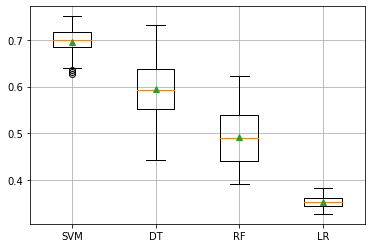

In [ ]:
# plotar o resumo da performance dos modelos candidatos
plot_results(results_scores_order, "comparativo_modelos_candidatos")

In [ ]:
# selecionar o modelo canditado com a melhor performance com base na métrica definida
model_select = results_scores_order[0]['model']

In [ ]:
# treinar o modelo selecionado com os dados de treinamento
model_select.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [ ]:
def save_model(model, filename):
  path = "/content/drive/MyDrive/tcc/models/"
  path_filename = path + filename
  dump(model, path_filename)
  print("Modelo selecionado salvo")

In [ ]:
# salvar modelo
save_model(model_select, 'model_select_version1.sav')

Modelo selecionado salvo
